In [22]:
import pandas as pd
import requests
from bs4 import BeautifulSoup, Comment
from io import StringIO
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

In [23]:
additional_coach_tables = pickle.load(open('additional_coach_tables.pkl', 'rb'))
coaching_history_combined = pd.read_pickle('coaching_history.pkl')
coaches_df = pd.read_pickle('coaches_df.pkl')
adjacency_matrix = pd.read_pickle('adjacency_matrix.pkl')


In [24]:
coaches_df.columns

Index(['Coach', 'Yrs', 'From', 'To', 'G', 'W', 'L', 'T', 'W-L%', 'G > .500',
       'Yr plyf', 'G plyf', 'W plyf', 'L plyf', 'W-L%.1', 'AvRk', 'BstRk',
       'Chmp', 'SBwl', 'Conf', 'HOF', 'Coach_Code', 'Coach_URL'],
      dtype='object')

In [25]:
coach_stats_no_playoff = coaches_df[["Coach", "Yrs", "G", "W", "T", "W-L%", 'G > .500', 'AvRk', 'BstRk', 'HOF']]

In [ ]:
# pd.set_option('display.max_rows', None)
# display(coach_stats_no_playoff)
# pd.reset_option('display.max_rows')

In [35]:
coach_stats_no_playoff = coach_stats_no_playoff.set_index("Coach")

In [41]:
coach_stats_no_playoff = coach_stats_no_playoff.astype('float64')
coach_stats_no_playoff.dtypes

Yrs         float64
G           float64
W           float64
T           float64
W-L%        float64
G > .500    float64
AvRk        float64
BstRk       float64
HOF         float64
dtype: object

In [42]:
type(coach_stats_no_playoff.values)

numpy.ndarray

In [ ]:
import torch
from torch_geometric.data import Data

node_features = torch.tensor(coach_stats_no_playoff.values, dtype=torch.float)

edge_indices = torch.tensor(np.array(np.where(adjacency_matrix == 1)), dtype=torch.long)

data = Data(x=node_features, 
           edge_index=edge_indices)

torch.save(data, 'nfl_coaches.pt')


In [ ]:
loaded_data = torch.load('nfl_coaches.pt', weights_only=False)
loaded_data

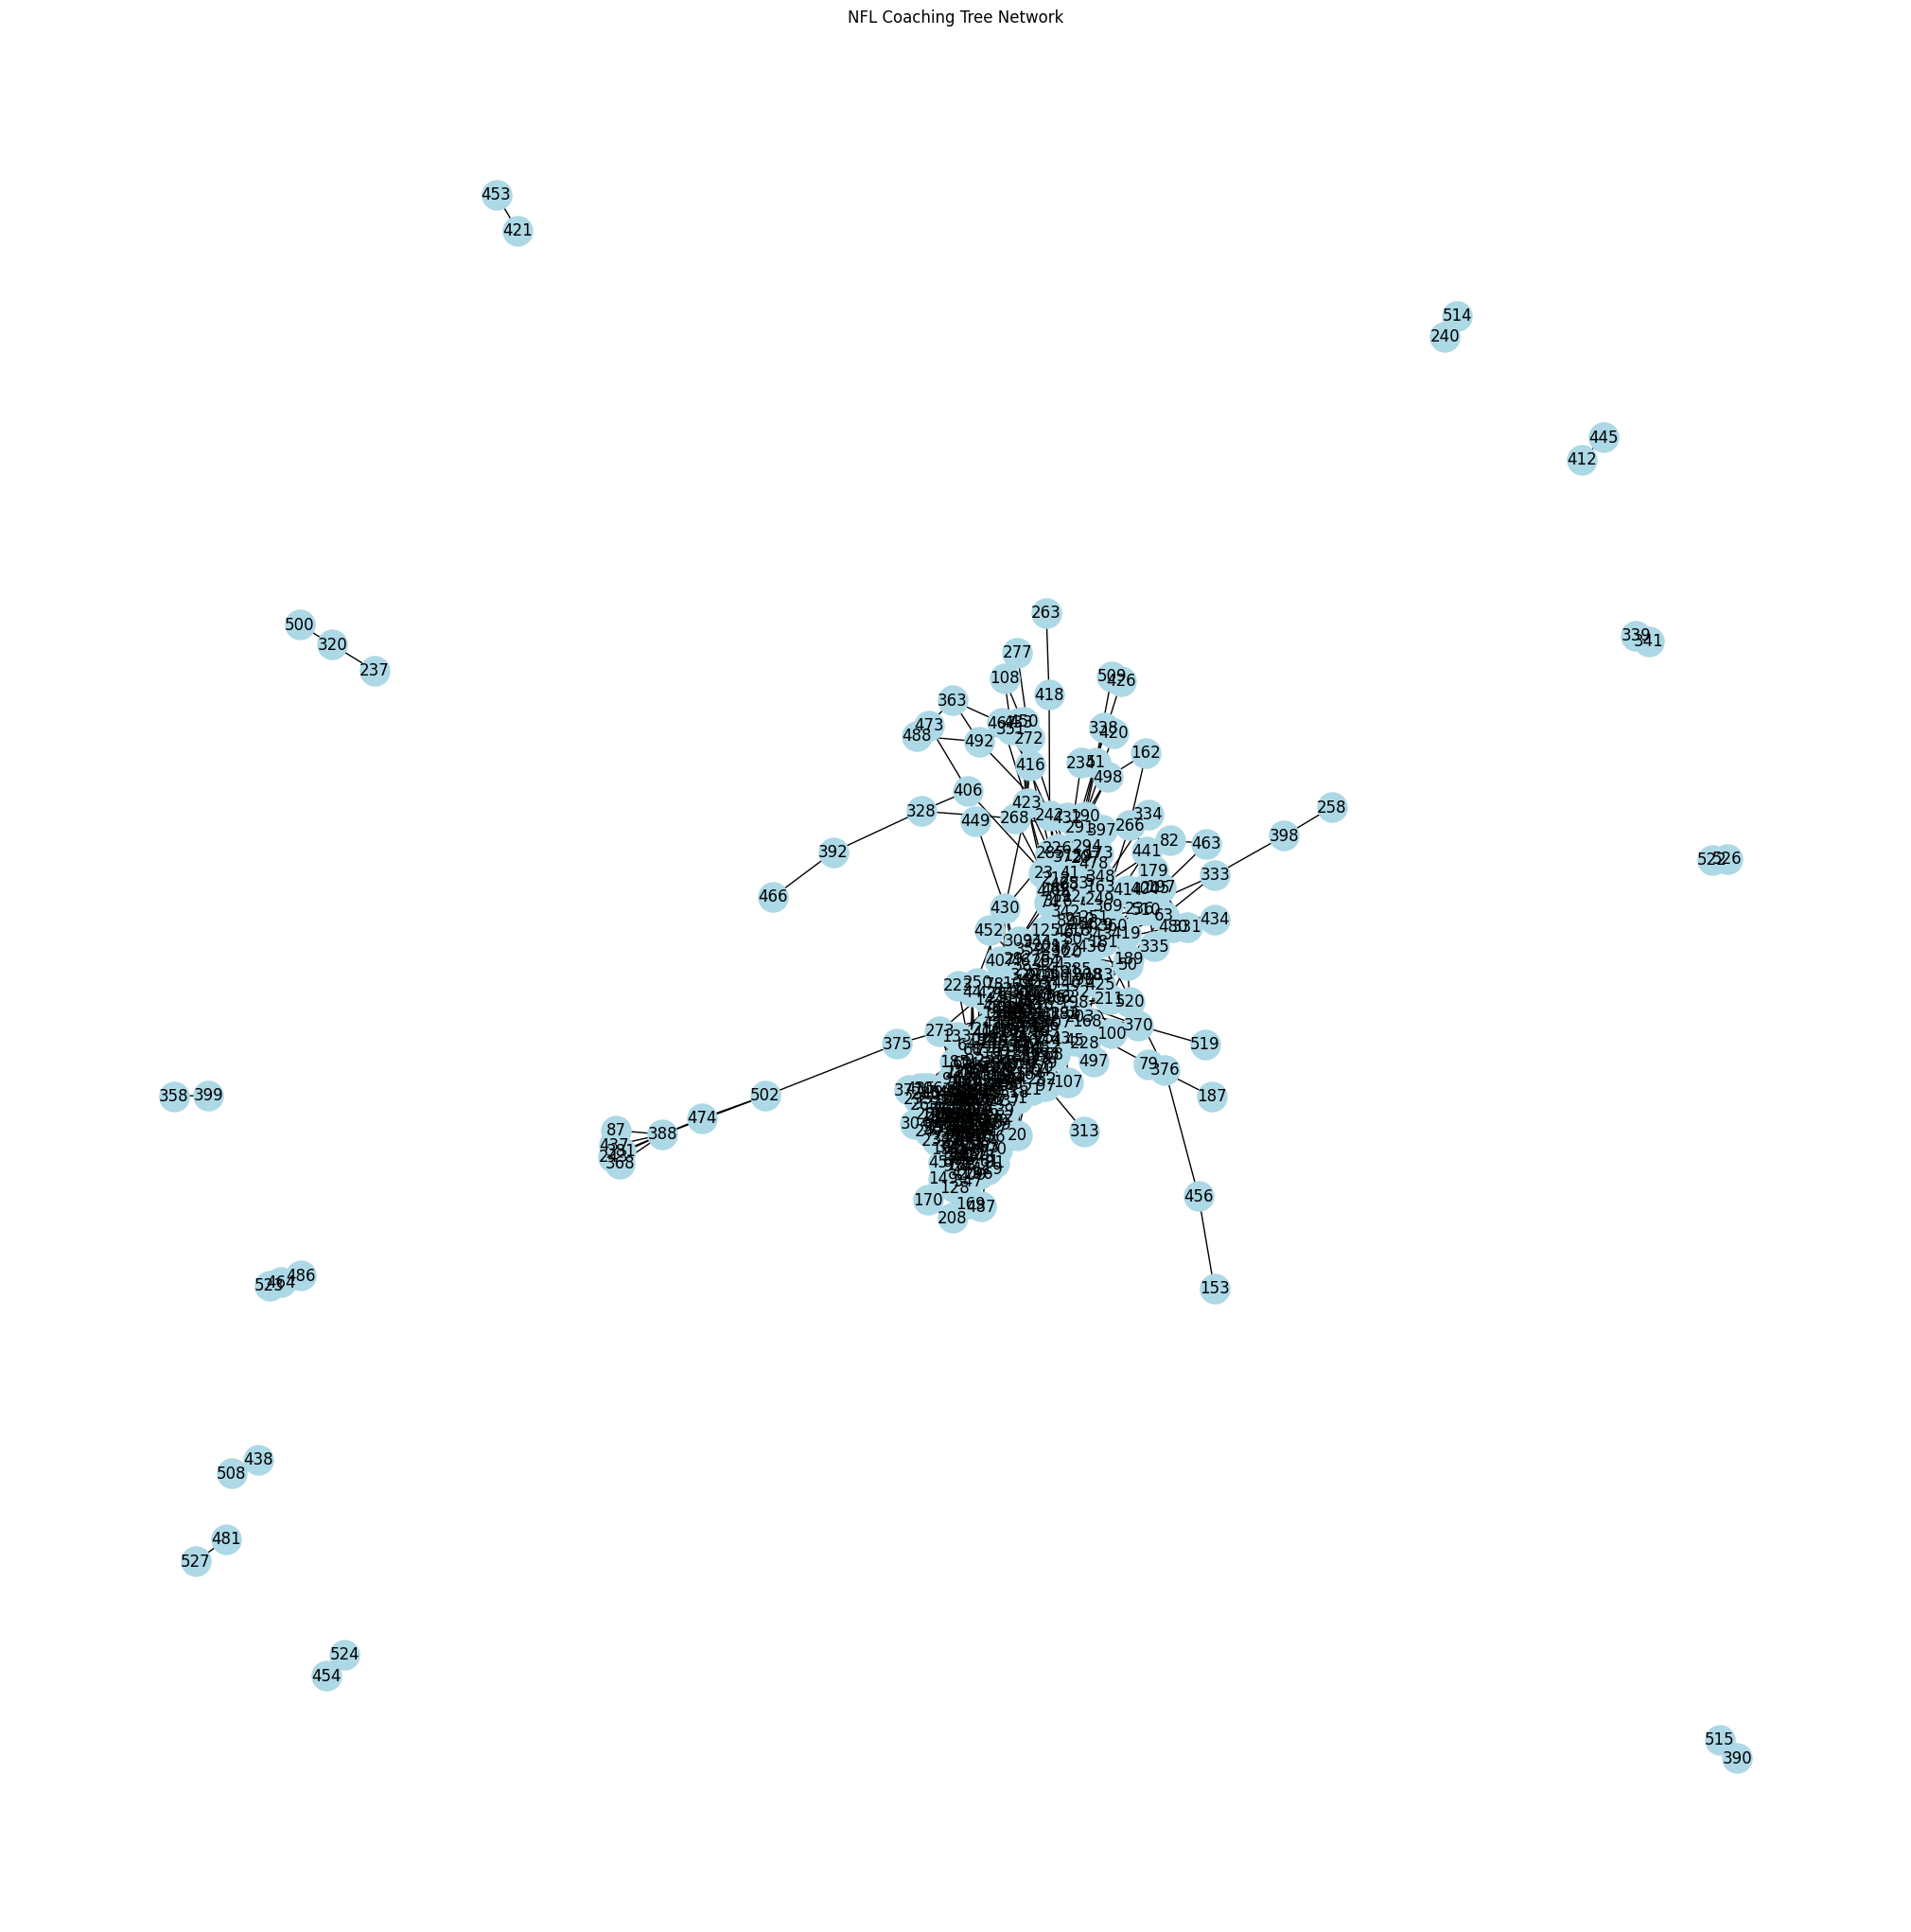

In [49]:
edge_index = loaded_data.edge_index.numpy()
G = nx.Graph()

for i in range(edge_index.shape[1]):
    G.add_edge(edge_index[0,i], edge_index[1,i])

plt.figure(figsize=(20,20))
pos = nx.spring_layout(G)
nx.draw(G, pos, 
        node_color='lightblue',
        node_size=500,
        with_labels=True)
plt.title("NFL Coaching Tree Network")
plt.show()


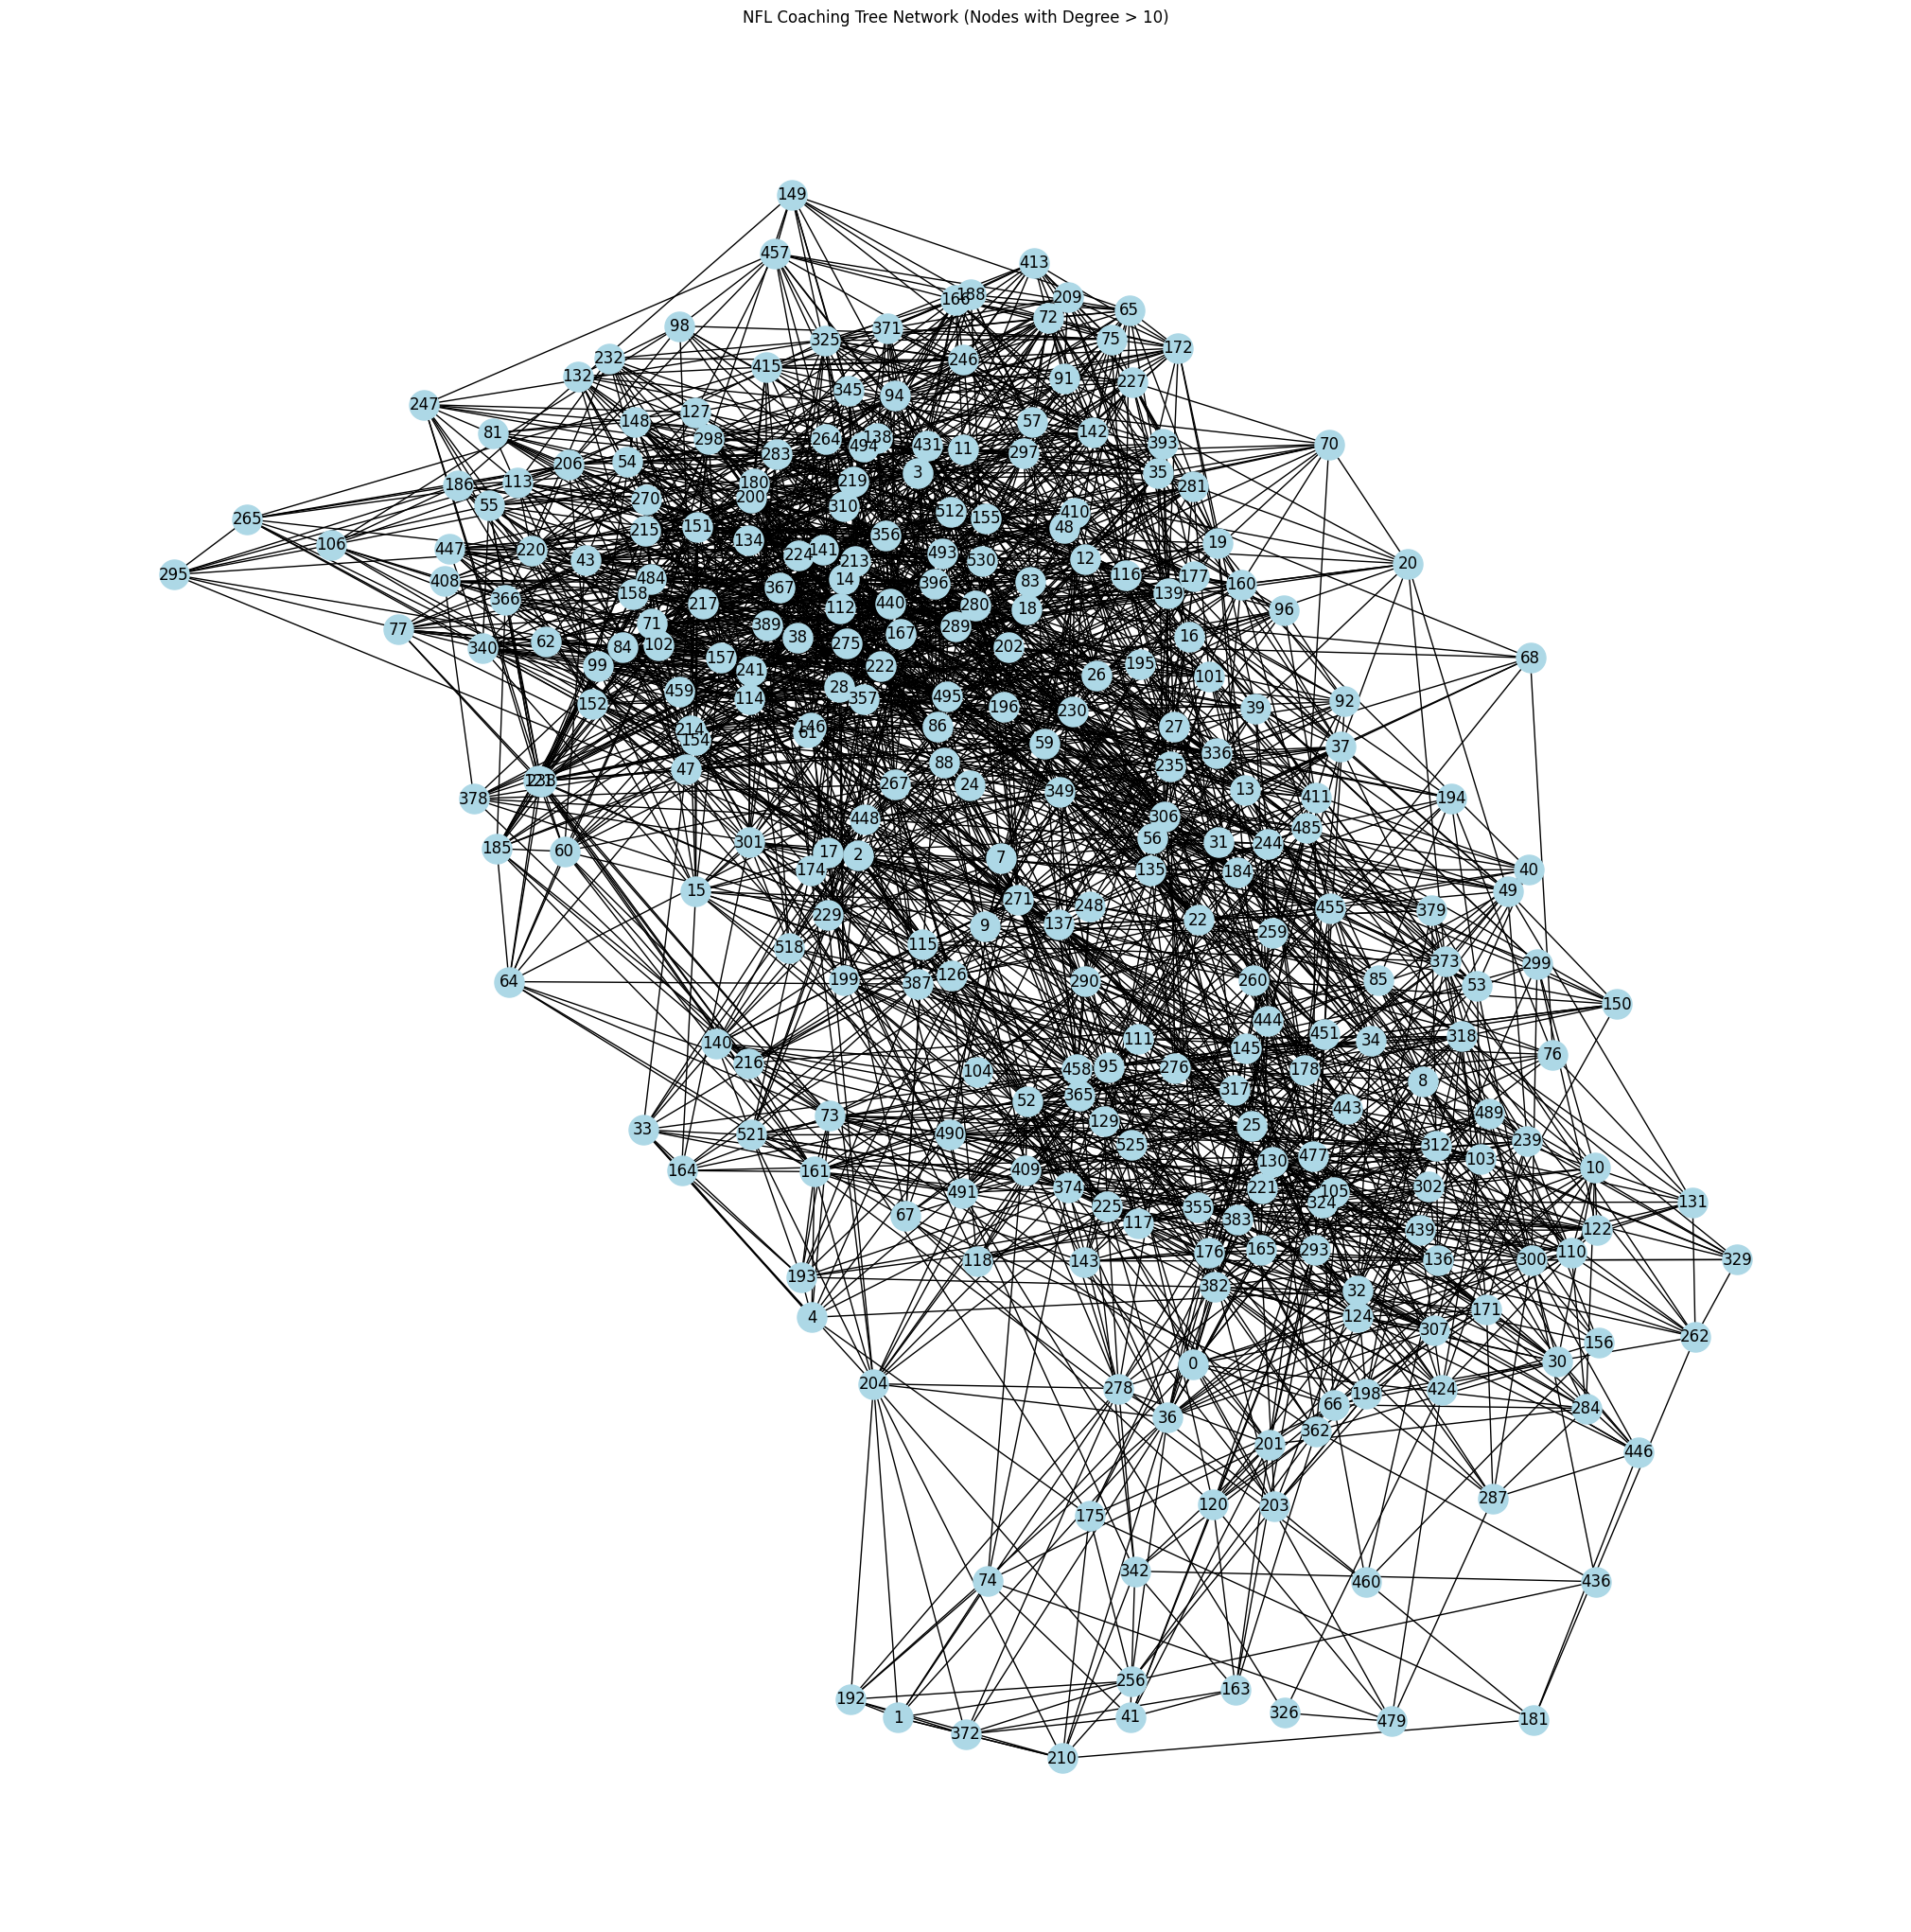

In [113]:
node_degrees = dict(G.degree())

high_degree_nodes = [node for node, degree in node_degrees.items() if degree > 10]

# Create mapping from old node indices to new consecutive indices
node_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(high_degree_nodes)}

G_subset = G.subgraph(high_degree_nodes)

# Create edge index using the new consecutive indices
subset_edge_index = np.array([[node_mapping[u], node_mapping[v]] 
                             for (u, v) in G_subset.edges()]).T

subset_node_features = node_features[high_degree_nodes]

sub_dataset = Data(x=subset_node_features,
                  edge_index=torch.tensor(subset_edge_index, dtype=torch.long))

torch.save(sub_dataset, 'nfl_coaches_subset.pt')

plt.figure(figsize=(20,20))
pos_subset = nx.spring_layout(G_subset)
nx.draw(G_subset, pos_subset,
        node_color='lightblue',
        node_size=500,
        with_labels=True)
plt.title("NFL Coaching Tree Network (Nodes with Degree > 10)")
plt.show()
